In [1]:
import numpy as np
from astropy.io import fits
import os, glob
import galsim
import tensorflow as tf
import tensorflow_addons as tfa
from censai.cosmos_utils import decode, preprocess
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch, ImageNormalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from censai.physical_model import PhysicalModel
from astropy.cosmology import Planck18 as cosmo
from astropy.constants import c, G,  M_sun
from astropy import units as u
from scipy.signal import tukey
import pandas as pd

In [2]:
pixels = 208
pixel_scale = 0.03
fov = pixels * pixel_scale

x = np.linspace(-1, 1, pixels) * fov
xx, yy = np.meshgrid(x, x)
def get_flux(image, hlr):
    sigma = hlr / 2 / np.log(2 * np.sqrt(2)) # hlr is fwhm of profile
    window = np.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
    window /= window.sum()
    flux = np.sum(window * image)
    return flux

### Window for source

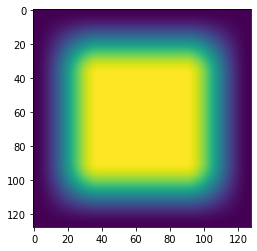

In [3]:
window = tukey(128, alpha=0.6)
window = np.outer(window, window)
plt.imshow(window)
window = window[np.newaxis, ..., np.newaxis]

# Exploration of catalog

In [4]:
catalog = galsim.COSMOSCatalog(sample="23.5", dir="/home/aadam/scratch/data/COSMOS/COSMOS_23.5_training_sample", exclusion_level="marginal")
# catalog = galsim.COSMOSCatalog(sample="25.2", dir="/home/aadam/scratch/data/COSMOS/COSMOS_25.2_training_sample", exclusion_level="marginal", min_hlr=2)
cat_param = catalog.param_cat[catalog.orig_index]

In [5]:
catalog.getNObjects()

50932

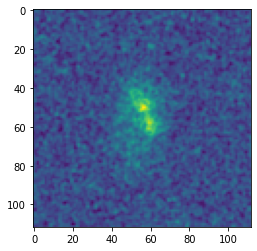

In [6]:
# basic drawing, no modification
# ind = 2499
# ind = 161
ind = 11


gal = catalog.makeGalaxy(ind, gal_type='real', noise_pad_size=1*pixels * pixel_scale)
psf = gal.original_psf
gal = galsim.Convolve(gal, psf)
# plt.imshow(gal.drawImage().array, cmap="bone", norm=ImageNormalize(stretch=LogStretch()))
plt.imshow(gal.drawImage().array)

In [7]:
cat_param["hlr"][:, 0] # sersic half light radius
# cat_param

array([0.70258482, 0.53038505, 0.16755118, ..., 0.54231332, 0.60721601,
       0.18147959])

In [8]:
# cat_param["flux"][:, 0]

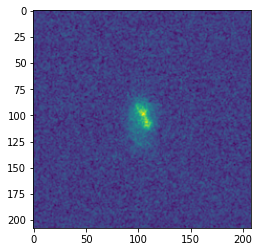

In [9]:
# draw on a fixed size stamp
im = gal.drawImage(nx=pixels, ny=pixels, scale=0.03, method='no_pixel', use_true_center=False).array.astype('float32')
# plt.imshow(im, cmap="bone", norm=ImageNormalize(stretch=LogStretch()))
plt.imshow(im)

In [10]:
# # hlr = gal.calculateHLR()
# hlr = cat_param["hlr"][ind, 0]
# sigma = hlr / 2 / np.log(2 * np.sqrt(2)) # hlr is fwhm of profile
# window = np.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
# window /= window.sum()
# plt.imshow(window * im)
# hlr

##### some interesting examples from the cosmos dataset 25.2
##### indices = [81005,80252,80203]

In [11]:
zd = 0.44
zs = 2.37
Ds = cosmo.angular_diameter_distance(zs)
Dd = cosmo.angular_diameter_distance(zd)
Dds = cosmo.angular_diameter_distance_z1z2(zd, zs)
sigma_crit = (c**2 * Ds / (4 * np.pi * G * Dd * Dds) / (1e10 * M_sun)).to(u.Mpc**(-2)).value
sigma_crit

196395.08907612518

In [12]:
ratio = 226713.6059585938 / sigma_crit 
ratio

1.1543751273267164

In [13]:
raw_datapath = "/home/aadam/scratch/data/COSMOS/COSMOS_25.2_training_sample"
tfrecords_datapath = "/home/aadam/scratch/Censai/data/cosmos_25.2/"
sample_tfrecord = os.path.join(tfrecords_datapath, "cosmos_record_80.tfrecords")

kappa_datapath = "/home/aadam/scratch/Censai/data/kappa612_200kpc_64neighbors/"

In [14]:
galaxy_data = tf.data.TFRecordDataset(sample_tfrecord).map(decode).map(preprocess)
galaxies = []
for (g, psf, ps) in galaxy_data:
#     print(np.sqrt(np.exp(ps[ps < 10].numpy().max())))
    galaxies.append(g)
#     break

In [15]:
kappa_data = []
i = 0
for file in os.listdir(kappa_datapath):
    kappa_data.append(fits.open(os.path.join(kappa_datapath, file)))
    if i == 100:
        break
    i += 1

In [16]:
kappa_data[0]["PRIMARY"].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  612                                                  
NAXIS2  =                  612                                                  
SUBID   =              1446192                                                  
MASS    =    241.2003476423276 / Total mass in the subhalo, in 10^{10} solar mas
CUTMASS =    161.6389044836814 / Total mass in the cutout in 10^{10} solar mass 
CREATED = '21-05-23_21-08-37'                                                   
OFFSET0 =           2212707227                                                  
OFFSET1 =           4016054830                                                  
OFFSET4 =            460715806                                                  
OFFSET5 =               1101

In [17]:
# estimate einstein ring for a given kappa map
z_s = 2.3
z_d = 0.4
Dd = cosmo.angular_diameter_distance(z_d)
Ds = cosmo.angular_diameter_distance(z_s)
Dds = cosmo.angular_diameter_distance_z1z2(z_d, z_s)
M = kappa_data[3]["PRIMARY"].header["CUTMASS"] * 1e10 * M_sun
theta_e = (np.sqrt(4 * G / c**2 * M * Dds / Ds / Dd).decompose() * u.rad).to(u.arcsec)
theta_e

<Quantity 7.11297727 arcsec>

In [18]:
# fov of kappa map given redshift and the chosen comoving size of the grids
fov = 0.18595909 * u.Mpc #/h for 512 pixels
fov = (fov * cosmo.h / cosmo.angular_diameter_distance(z_d) * (180 / np.pi * 3600)).decompose()
fov

<Quantity 22.70636658>

In [19]:
m = [g.numpy().max() for g in galaxies]

In [20]:
[(_m, i) for i, _m in enumerate(m) if _m > 0.5]

[(0.80964667, 14),
 (0.5257895, 89),
 (0.9720869, 98),
 (0.64894766, 253),
 (1.1765397, 261),
 (0.6556503, 307),
 (1.2032963, 349),
 (0.78535867, 355),
 (1.4817048, 385),
 (0.6626011, 403),
 (0.5131483, 557),
 (0.5293219, 601),
 (0.50553554, 651),
 (1.9971269, 701),
 (2.0204146, 783),
 (0.87531227, 786),
 (1.2429297, 807),
 (0.92020285, 830),
 (1.6901392, 873),
 (0.6991334, 959),
 (0.7776954, 994)]

In [26]:
kap_id = 8
# kap_id = 3
# kap_id = 5
# gal_id = 203
# gal_id = 783
gal_id = 994
# gal_id = 10

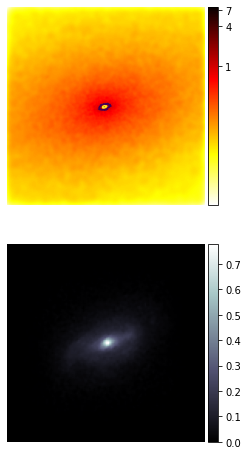

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8))

im = ax1.imshow(kappa_data[kap_id][0].data, cmap="hot_r", norm=ImageNormalize(stretch=LogStretch()))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.locator_params(nbins=3)
ax1.contour(kappa_data[kap_id][0].data, levels=[1, 2])
ax1.axis("off");

im = ax2.imshow(window[0] * galaxies[gal_id], cmap="bone")#, norm=ImageNormalize(stretch=LogStretch()))
# im = ax2.imshow(np.arcsinh(galaxies[gal_id]), cmap="gray")
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax2.axis("off");

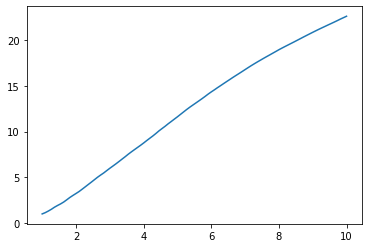

In [28]:
physical_fov = 0.18595909 * u.Mpc # in comoving coordinates
thetas = []
rs = np.linspace(1, 10, 100)
sigma_crit = (c**2 * Ds / (4 * np.pi * G * Dd * Dds)).to(u.kg * u.Mpc**(-2))
shift_center = [0, 0]

# rescaling vs einstein radius
for r in rs:
    kap = r * kappa_data[kap_id][0].data[50 + shift_center[0]: -(50 - shift_center[0]), 50 + shift_center[1]: -(50 - shift_center[1])][np.newaxis, ..., np.newaxis]
    M = np.sum(kap[kap > 1]) * sigma_crit * (physical_fov/512)**2
    theta_e = (np.sqrt(4 * G / c**2 * M * Dds / Ds / Dd).decompose() * u.rad).to(u.arcsec).value
    thetas.append(theta_e)
plt.plot(rs, thetas)

In [29]:
from scipy.stats import linregress
linregress(rs, thetas)

LinregressResult(slope=2.5167608557557504, intercept=-1.375021868530295, rvalue=0.9975941733504816, pvalue=2.0561385445433964e-115, stderr=0.017666918507258822)

### Not the same slope for every profile

In [ ]:
shift_center = [0, 0] # max 50 pixel shift
kap = 4*kappa_data[kap_id][0].data[50 + shift_center[0]: -(50 - shift_center[0]), 50 + shift_center[1]: -(50 - shift_center[1])][np.newaxis, ..., np.newaxis]

# M = 0.05 * kappa_data[kap_id]["PRIMARY"].header["CUTMASS"] * 1e10 * M_sun  # one very rought estimate of M(theta_E)
physical_fov = 0.18595909 * u.Mpc # in comoving coordinates
# M = np.sum(kap[kap > 1]) * 1e10*M_sun / u.Mpc**2 * (physical_fov)**2  # Estimate of M(theta_E)
M = np.sum(kap[kap > 1]) * sigma_crit * (physical_fov/512)**2
theta_e = (np.sqrt(4 * G / c**2 * M * Dds / Ds / Dd).decompose() * u.rad).to(u.arcsec).value
print(theta_e)
plt.imshow(kap[0, ..., 0], cmap="hot_r", norm=ImageNormalize(stretch=LogStretch()))

In [ ]:
image_fov = 16
source = window * galaxies[gal_id][np.newaxis, ...]
# source = tf.random.normal([1, 128, 128, 1])


phys = PhysicalModel(image_side=image_fov, src_side=3, pixels=512, src_pixels=128, kappa_side=fov, method="conv2d")
lens = phys.noisy_forward(source=source, kappa=kap, noise_rms=1e-8) # 3e-3

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(lens[0, ..., 0], cmap="hot", extent=[-image_fov/2, image_fov/2]*2)#, norm=ImageNormalize(stretch=LogStretch()))
plt.axvline(theta_e, lw=2, color="w")
# plt.axis("off");

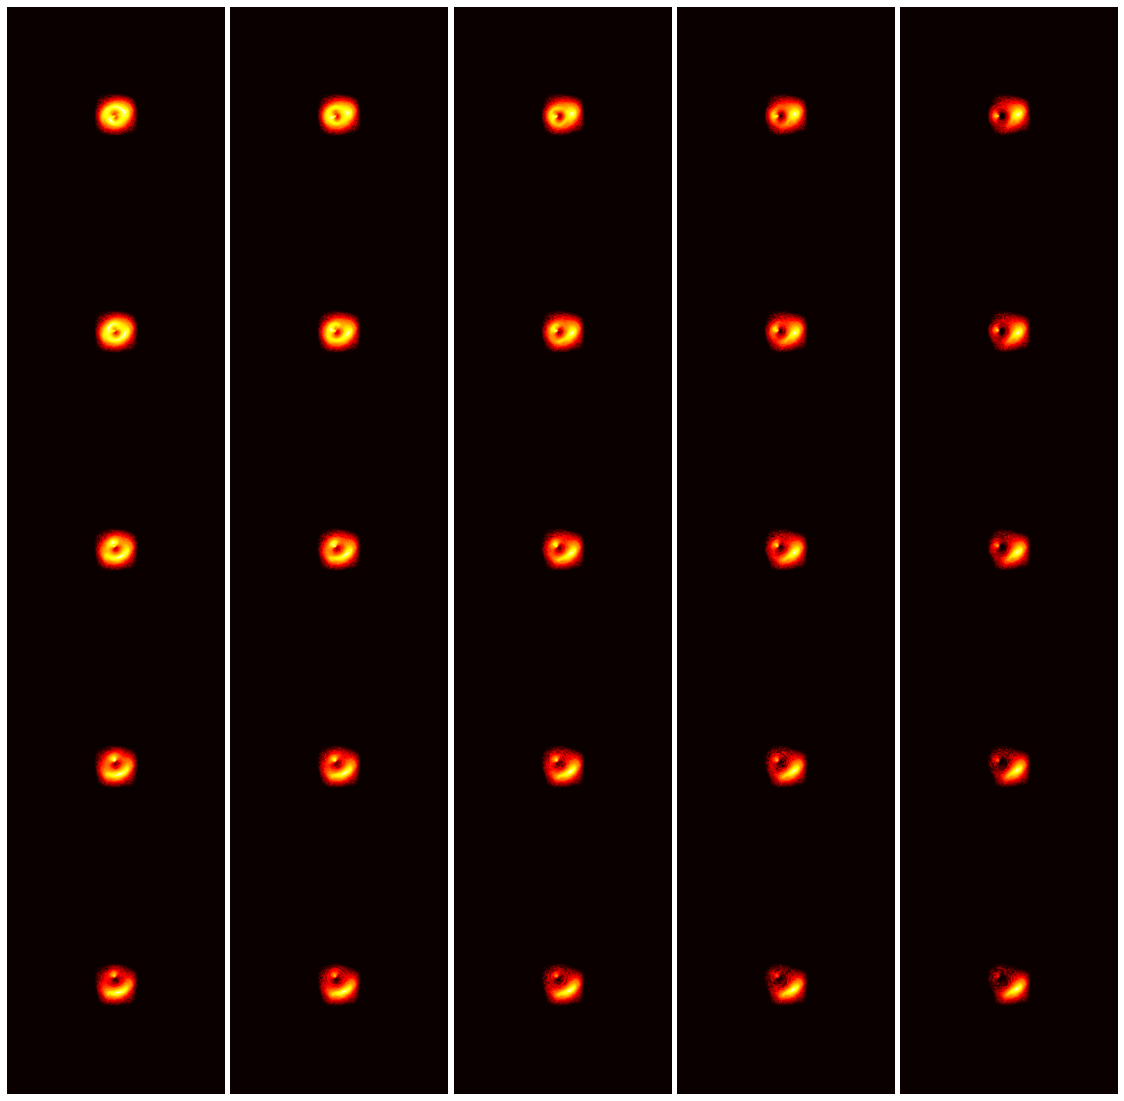

In [120]:
phys = PhysicalModel(image_side=16, src_side=2, pixels=512, src_pixels=128, kappa_side=20, method="conv2d")
ncol=5
nrow=5

fig, axs = plt.subplots(ncol, nrow, figsize=(20, 20))
for i in range(ncol):
    for j in range(nrow):      
        shift_center = [5*i, 5*j] # max 50 pixel shift
        kap = kappa_data[kap_id][0].data[50 + shift_center[0]: -(50 - shift_center[0]), 50 + shift_center[1]: -(50 - shift_center[1])][np.newaxis, ..., np.newaxis]
        lens = phys.noisy_forward(source=window * galaxies[gal_id][np.newaxis, ...], kappa=kap, noise_rms=1e-6)
        axs[i, j].imshow(lens[0, ..., 0], cmap="hot", norm=ImageNormalize(stretch=LogStretch()))
        axs[i, j].axis("off")
        
plt.subplots_adjust(wspace=.0, hspace=.0)

In [28]:
im, jac = phys.lens_source_and_compute_jacobian(source=galaxies[gal_id][np.newaxis, ...], kappa=kap*10)

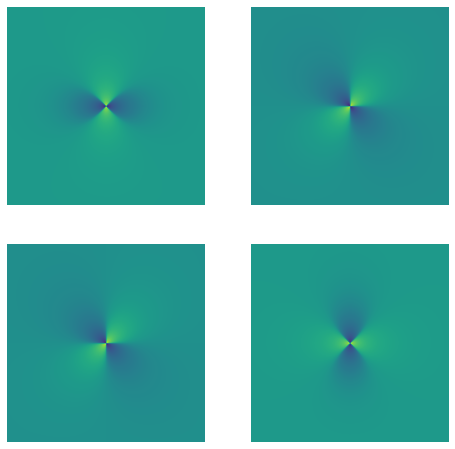

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    for j in range(2):
        axs[i, j].imshow(np.arcsinh(jac[0, ..., i, j]))
        axs[i, j].axis("off")
# plt.subplots_adjust(wspace=.0, hspace=.0)

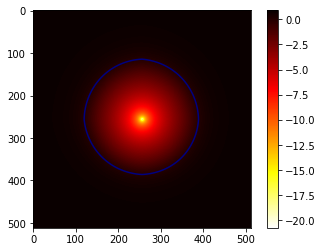

In [51]:
jac_det = tf.linalg.det(jac)
plt.imshow(np.arcsinh(jac_det[0]), cmap="hot_r")
plt.colorbar()
plt.contour(jac_det[0], levels=[0], cmap="jet")
# plt.imshow(jac_det[0])


In [43]:
jac_det

<tf.Tensor: shape=(1, 512, 512), dtype=float32, numpy=
array([[[0.99511826, 0.9950336 , 0.9949493 , ..., 0.99812955,
         0.9981749 , 0.99821866],
        [0.99503577, 0.9949496 , 0.9948635 , ..., 0.9980926 ,
         0.99813914, 0.9981839 ],
        [0.99495274, 0.9948648 , 0.9947771 , ..., 0.9980555 ,
         0.9981028 , 0.99814856],
        ...,
        [0.99918294, 0.9991645 , 0.9991459 , ..., 0.998795  ,
         0.9988193 , 0.99884284],
        [0.99920803, 0.99919045, 0.99917245, ..., 0.99882203,
         0.9988455 , 0.99886864],
        [0.9992323 , 0.9992152 , 0.99919784, ..., 0.99884844,
         0.99887156, 0.9988937 ]]], dtype=float32)>

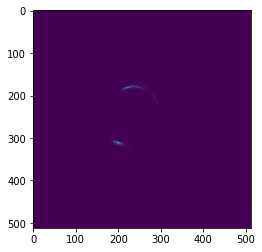

In [31]:
plt.imshow(im[0, ..., 0])

In [32]:
jac.shape

TensorShape([1, 512, 512, 2, 2])